#Ebird Data Processing & Notes

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
import pandas as pd
import numpy as np
from pathlib import Path
import logging
from typing import Callable, Union, Optional
import os
from math import radians, cos, sin, asin, sqrt, atan2

In [6]:
## load i95_coordinates in shared drive - modify path as needed ##
i95_coordinates = pd.read_csv('/content/drive/MyDrive/Capstone/i95_modified.csv')

In [7]:
# Sort I-95 coordinates by sequence to ensure proper ordering
i95_sorted = i95_coordinates.sort_values(['Overall_Sequence'])

# Convert I-95 DataFrame to list of coordinate tuples
i95_coords = list(zip(i95_sorted['Latitude'], i95_sorted['Longitude']))

In [10]:
i95_coords[:5]

[(37.6805651, -77.4510459),
 (37.6810755, -77.4512403),
 (37.6817698, -77.4514702),
 (37.6825313, -77.4516793),
 (37.6835617, -77.4518668)]

In [11]:
i95_coordinates.describe()

,Segment_Number,Point_Order,Longitude,Latitude,Overall_Sequence
count,55654.000000,55654.000000,55654.000000,55654.000000,55654.000000
mean,3195.397258,13.591260,-75.894609,37.261653,27826.500000
std,1938.028719,21.146372,3.850592,5.681084,16066.070278
min,0.000000,0.000000,-81.686619,25.749165,0.000000
25%,1558.000000,1.000000,-80.067069,33.904715,13913.250000
50%,3217.000000,6.000000,-76.489987,39.354663,27826.500000
75%,4762.000000,16.000000,-72.914974,41.284999,41739.750000
max,6974.000000,210.000000,-67.781085,46.145416,55653.000000


###Ebird data pre-processing
- read in the data in "chunk_size" batches
- select features of interests
- filter by date range: year >= 2019
- save as "filtered_data" ** modify file name to not overwrite other's.


In [ ]:
file_path = "ebd_US-PA_smp_relApr-2025.txt"

# Specify columns to keep
columns_to_keep = [
    'COMMON NAME', 'SCIENTIFIC NAME', 'OBSERVATION COUNT', 'COUNTRY', 'STATE', 'COUNTY',
    'LOCALITY', 'LATITUDE', 'LONGITUDE', 'OBSERVATION DATE',
    'TIME OBSERVATIONS STARTED', 'DURATION MINUTES'
]

# Set chunk size
chunk_size = 25000

# Output DataFrame
filtered_data = []

# Read file in chunks
for chunk in pd.read_csv(file_path, sep="\t", chunksize=chunk_size, dtype=str, on_bad_lines='skip'):
    # Drop rows that don't have exactly 53 or more columns
    if chunk.shape[1] < 53:
        continue

    # Convert date column
    chunk['OBSERVATION DATE'] = pd.to_datetime(chunk['OBSERVATION DATE'], errors='coerce')

    # # Filter for year >= 2019 :  Not needed for DC, Delaware and Maryland
    # chunk = chunk[chunk['OBSERVATION DATE'].dt.year >= 2019]

    # Apply columns to keep (skip chunk if any required column is missing)
    if all(col in chunk.columns for col in columns_to_keep):
        filtered_data.append(chunk[columns_to_keep])

# Combine all filtered chunks
result_df = pd.concat(filtered_data, ignore_index=True)

# Save to CSV
result_df.to_csv("filtered_data.csv", index=False)


###Batch process to add distance from i95 to state ebird data

Run below to code to determne available RAM to determine the batch size
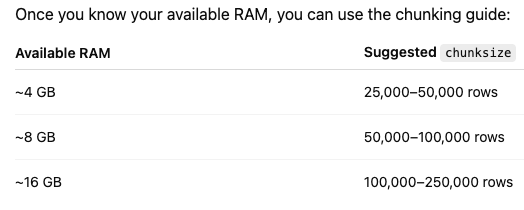

In [12]:
# Code to find available RAM
import psutil

mem = psutil.virtual_memory()
print(f"Total RAM: {mem.total / (1024 ** 3):.2f} GB")
print(f"Available RAM: {mem.available / (1024 ** 3):.2f} GB")

Total RAM: 12.67 GB
Available RAM: 11.26 GB


In [ ]:
# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Define BatchProcessor
class BatchProcessor:
    """
    A pipeline for processing large datasets in batches with add_i95_distances functions,
    filtering, and saving results.
    """

    def __init__(self,
                input_file: str = "filtered_data.csv",
                output_file: str = "pa_filtered.csv",
                batch_size: int = 25000,
                distance_threshold: float = None,
                i95_coords: list = None):


        self.input_file = input_file
        self.output_file = output_file
        self.batch_size = batch_size
        self.distance_threshold = distance_threshold
        self.i95_coords = i95_coords

        # Statistics tracking
        self.total_rows_processed = 0
        self.total_rows_saved = 0
        self.batch_count = 0

    @staticmethod
    def haversine_distance(lat1, lon1, lat2, lon2):
            """
            Calculate the great circle distance between two points
            on the earth (specified in decimal degrees)
            Returns distance in miles
            """
            # Convert decimal degrees to radians
            lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

            # Haversine formula
            dlat = lat2 - lat1
            dlon = lon2 - lon1
            a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
            c = 2 * asin(sqrt(a))

            # Radius of earth in miles
            r = 3956
            return c * r

    @staticmethod
    def bearing(lat1, lon1, lat2, lon2):
        """Calculate the bearing between two points"""
        lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
        dlon = lon2 - lon1
        y = sin(dlon) * cos(lat2)
        x = cos(lat1) * sin(lat2) - sin(lat1) * cos(lat2) * cos(dlon)
        return atan2(y, x)

    @staticmethod
    def distance_point_to_line_segment(point_lat, point_lon, seg_lat1, seg_lon1, seg_lat2, seg_lon2):
        """
        Calculate the shortest distance from a point to a line segment on Earth's surface
        This handles the continuous nature of the highway between coordinate points
        Returns distance in miles
        """
        # Distance from point to both endpoints
        d1 = BatchProcessor.haversine_distance(point_lat, point_lon, seg_lat1, seg_lon1)
        d2 = BatchProcessor.haversine_distance(point_lat, point_lon, seg_lat2, seg_lon2)

        # Length of the segment
        seg_length = BatchProcessor.haversine_distance(seg_lat1, seg_lon1, seg_lat2, seg_lon2)

        # If segment has zero length, return distance to the point
        if seg_length == 0:
            return d1

        # Calculate cross-track distance (perpendicular distance to the great circle)

        try:
            # Bearing from seg_start to seg_end
            bearing_seg = BatchProcessor.bearing(seg_lat1, seg_lon1, seg_lat2, seg_lon2)
            # Bearing from seg_start to point
            bearing_point = BatchProcessor.bearing(seg_lat1, seg_lon1, point_lat, point_lon)

            # Angular difference
            angle_diff = bearing_point - bearing_seg

            # Cross-track distance
            cross_track = asin(sin(d1 / 3956) * sin(angle_diff)) * 3956

            # Along-track distance (how far along the segment the closest point is)
            along_track = asin(sqrt(sin(d1 / 3956)**2 - sin(cross_track / 3956)**2)) * 3956

            # Check if the closest point on the infinite line falls within the segment
            if along_track < 0 or along_track > seg_length:
                # Closest point is beyond the segment endpoints
                return min(d1, d2)
            else:
                # Closest point is on the segment
                return abs(cross_track)

        except:
            # If calculation fails, return minimum distance to endpoints
            return min(d1, d2)

    def find_min_distance_to_highway(self, obs_lat, obs_lon):
        """
        Find the minimum distance from an observation coordinate to any part of the highway
        Treats highway as continuous line segments between consecutive points
        """
        min_distance = float('inf')

        # Early termination optimization - if we find a very close point, we can stop
        early_termination_threshold = 0.1  # miles

        # Check distance to each line segment of the highway
        for i in range(len(self.i95_coords) - 1):
            lat1, lon1 = self.i95_coords[i]
            lat2, lon2 = self.i95_coords[i + 1]

            # Quick distance check to segment start point first
            quick_distance = self.haversine_distance(obs_lat, obs_lon, lat1, lon1)

            # If we're already very far from this segment start, skip detailed calculation
            if quick_distance > min_distance + 30:  # 30 mile buffer
                continue

            # Distance to this line segment
            distance = self.distance_point_to_line_segment(
                obs_lat, obs_lon, lat1, lon1, lat2, lon2
            )

            min_distance = min(min_distance, distance)
            # Early termination if we find a very close match
            if min_distance < early_termination_threshold:
                break

        return min_distance

    def add_i95_distances(self, obs_coordinates: pd.DataFrame) -> pd.DataFrame:
        """
        This is a function that receives a DataFrame of observation coordinates
        and calculates the distance to the I-95 highway for each observation.:
        - Takes a pandas DataFrame as input
        - Adds a new column with distance calculations
        - Returns the modified DataFrame
        """
        distances = []
        for idx, row in obs_coordinates.iterrows():
            try:
                # Extract latitude and longitude from the row
                obs_lat = row['LATITUDE']
                obs_lon = row['LONGITUDE']

                # Find minimum distance to highway (considering it as continuous line segments)
                min_dist = self.find_min_distance_to_highway(obs_lat, obs_lon)
                # min_dist = self.find_min_distance_to_highway(obs_lat, obs_lon)
                distances.append(min_dist)
            except (ValueError, KeyError) as e:
                logger.warning(f"Error processing row {idx}: {e}")
                distances.append(np.nan)

        # Add distance column to dataframe
        result_df = obs_coordinates.copy()
        result_df['i95_distance'] = distances

        return result_df

    def process_batch(self,
                     batch_df: pd.DataFrame) -> pd.DataFrame:

        # Apply the add_i95_distances function
        processed_df = self.add_i95_distances(batch_df)

        # Filter by distance if threshold is specified
        if self.distance_threshold is not None:
            distance_col = 'i95_distance'

            if distance_col in processed_df.columns:
                filtered_df = processed_df[processed_df[distance_col] <= self.distance_threshold]
                logger.info(f"Filtered {len(batch_df)} rows to {len(filtered_df)} rows "
                           f"(threshold: {self.distance_threshold})")
            else:
                logger.warning(f"Distance column '{distance_col}' not found. No filtering applied.")
                filtered_df = processed_df
        else:
            filtered_df = processed_df

        return filtered_df

    def _process_one_batch(self, batch_df: pd.DataFrame):

        self.batch_count += 1
        self.total_rows_processed += len(batch_df)

        logger.info(f"Processing batch {self.batch_count} with {len(batch_df)} rows")

        # Process the batch
        processed_batch = self.process_batch(batch_df)
        self.total_rows_saved += len(processed_batch)

        return processed_batch


    def run_pipeline(self) -> dict:

        logger.info(f"Starting pipeline processing: {self.input_file}")
        logger.info(f"Batch size: {self.batch_size}")
        logger.info(f"Distance threshold: {self.distance_threshold}")

        all_processed_data = []

        try:
            # Read the CSV file in chunks
            chunk_iter = pd.read_csv(self.input_file, chunksize=self.batch_size)

            for chunk in chunk_iter:
                processed_chunk = self._process_one_batch(chunk)
                all_processed_data.append(processed_chunk)

            # Combine all processed chunks
            if all_processed_data:
                final_df = pd.concat(all_processed_data, ignore_index=True)

                # Save the final result
                final_df.to_csv(self.output_file, index=False)
                logger.info(f"Saved final dataset with {len(final_df)} rows to {self.output_file}")
            else:
                logger.warning("No data was processed")
                final_df = pd.DataFrame()

        except Exception as e:
            logger.error(f"Error processing pipeline: {str(e)}")
            raise

        stats = {
            'total_rows_processed': self.total_rows_processed,
            'total_rows_saved': self.total_rows_saved,
            'total_batches': self.batch_count,
            'output_file': self.output_file,
            'filter_efficiency': (self.total_rows_saved / self.total_rows_processed * 100)
                                if self.total_rows_processed > 0 else 0
        }

        logger.info("Pipeline completed successfully!")
        logger.info(f"Statistics: {stats}")
        return stats


In [ ]:
# Specify file names, batch size, distance  and run this cell to execute batch processing
if __name__ == "__main__":
    # Since i95_coords is already defined as a global variable, use it directly

    # Create processor instance
    processor = BatchProcessor(
        input_file="filtered_data.csv",
        output_file="pa_filtered.csv",
        batch_size=25000,  # Adjust based on your memory constraints
        distance_threshold=25,  # Set a distance threshold to filter
        i95_coords=i95_coords
    )

    # Run the pipeline
    results = processor.run_pipeline()
    print("Processing complete!")
    print(f"Results: {results}")